# Diabetes in 130 US hospitals for the years 1999 to 2008

**Abstract**: This data has been prepared to analyze factors related to readmission as well as other outcomes pertaining to patients with diabetes.

**Data Set Information**: The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

 1. It is an inpatient encounter (a hospital admission).
 2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
 3. The length of stay was at least 1 day and at most 14 days.
 4. Laboratory tests were performed during the encounter.
 5. Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

More information can be found at the [Diabetes 130-US hospitals for years 1999-2008 data set - UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) web site.

 - [Summary of data preparation](#Summary-of-data-preparation)
 - [Loading data](#Loading-data)
 - [Exploratory data analysis](#Exploratory-data-analysis)
 - [Data cleaning](#Data-cleaning)
   - [Removing null and bias values](#Removing-null-and-bias-values)
   - [Grouping primary diagnosis values into group categories](#Grouping-primary-diagnosis-values-into-group-categories)
   - [Grouping '> 30 days' and `< 30 days' into the 'Yes' category in the 'readmitted' column](#Grouping-%3E-30-days-and-%3C-30-days-into-the-Yes-category-in-the-readmitted-column)
   - [Converting categorical variables into dummy variables](#Converting-categorical-variables-into-dummy-variables)
 - [Saving results](#Saving-results)

# Summary of data preparation

 - Converting the `admission_type_id` ,`discharge_disposition_id` and `admission_source_id` numerical columns to categorical values.
 - All of the `object` values, which are text values in the CSV file, are converted to categorical values.
 - In the `Exploratory data analysis` section, we remove: 
   - all `NaN` values from the data, and the `Unknown/Invalid` category from the `Gender` category,
   - `weight`, `medical_specialty` and `payer_code` columns due to the large presence of `NaN` values,
   - `encounter_id` column since it isn't relevant to the analysis,
   - not available, null, not mapped and unknown/invaild admission type and admission source IDs,
   - duplicate patient data to maintain the statistical independence of the data, required by logistic regression, after which the `patient_nbr` column is dropped.
   - all patient data related to discharge to a hospice or patient death are removed to avoid biases. Null patient values are remove as well.
 - `diag_1` values are encoded into nine major groups: `circulatory`, `respiratory`, `digestive`, `diabetes`, `injury`, `musculoskeletal`, `genitourinary`, `neoplasms` and `others`. All subsequent `NaN` values are dropped.
 - `readmitted` column is divided into two `0` and `1` categories, where the `1` category groups the two `< 30 days` and `> 30 days` cases together.
 - Dummy variables are created for all columns except for the eight numerical columns: `time_in_hospital`, `num_lab_procedures`, `num_medications`, `number_outpatient`, `number_emergency`, `number_inpatient`, `number_diagnoses` and `readmitted`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

# Loading data

In [3]:
df = pd.read_csv('data/diabetic_data.csv', na_values='?', low_memory=False)
obj_cols = list(df.select_dtypes('object').columns)
df[obj_cols] = df[obj_cols].astype('category')

Converting the `admission_type_id` ,`discharge_disposition_id` and `admission_source_id` numerical columns to categorical values.

In [4]:
id_list = ['admission_type_id' ,'discharge_disposition_id', 'admission_source_id']
df.loc[:, id_list] = df.loc[:, id_list].astype('category')

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null category
gender                      101766 non-null category
age                         101766 non-null category
weight                      3197 non-null category
admission_type_id           101766 non-null category
discharge_disposition_id    101766 non-null category
admission_source_id         101766 non-null category
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null category
medical_specialty           51817 non-null category
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient 

In [7]:
df.nunique().sort_values(ascending=False)

encounter_id                101766
patient_nbr                 71518 
diag_3                      789   
diag_2                      748   
diag_1                      716   
num_lab_procedures          118   
num_medications             75    
medical_specialty           72    
number_outpatient           39    
number_emergency            33    
discharge_disposition_id    26    
number_inpatient            21    
admission_source_id         17    
payer_code                  17    
number_diagnoses            16    
time_in_hospital            14    
age                         10    
weight                      9     
admission_type_id           8     
num_procedures              7     
race                        5     
repaglinide                 4     
max_glu_serum               4     
A1Cresult                   4     
metformin                   4     
rosiglitazone               4     
pioglitazone                4     
insulin                     4     
nateglinide         

In [8]:
df.describe().applymap('{:.1f}'.format)

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0
mean,165201645.6,54330400.7,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4
std,102640296.0,38696359.3,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9
min,12522.0,135.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
25%,84961194.0,23413221.0,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0
50%,152388987.0,45505143.0,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0
75%,230270887.5,87545949.8,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0
max,443867222.0,189502619.0,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0


# Exploratory data analysis

In [9]:
missing_values = df.isnull().sum()/df.shape[0]*100
missing_values.sort_values(ascending=True, inplace=True)
missing_df = missing_values.reset_index().rename(columns={'index': 'Features', 0: 'Values'})
missing_df['Values'] = missing_df['Values'].apply('{:.1f}'.format).astype('float')

In [10]:
missing_df = missing_df.loc[missing_df['Values'] != 0].sort_values(by='Values', ascending=False)
missing_df.head(10)

,Features,Values
49,weight,96.9
48,medical_specialty,49.1
47,payer_code,39.6
46,race,2.2
45,diag_3,1.4
44,diag_2,0.4


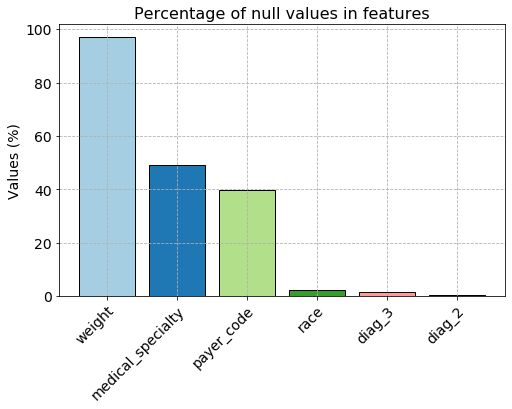

In [11]:
fig, axes = plt.subplots(figsize=(8, 5))
axes.bar(missing_df['Features'], missing_df['Values'], color=plt.cm.Paired.colors, edgecolor='k')
plt.setp(axes.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=14)
plt.setp(axes.get_yticklabels(), fontsize=14)
axes.set_ylabel('Values (%)', fontsize=14)
axes.set_title('Percentage of null values in features', fontsize=16)
plt.grid(True, linestyle='--');

In [12]:
df['race'].unique()

[Caucasian, AfricanAmerican, NaN, Other, Asian, Hispanic]
Categories (5, object): [Caucasian, AfricanAmerican, Other, Asian, Hispanic]

From the bar plot below, we can drop the `NaN` values from race without concern.

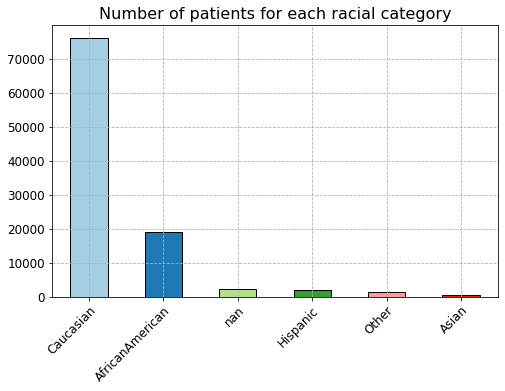

In [13]:
race_sorted_df = df['race'].value_counts(dropna=False)
ax = race_sorted_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Number of patients for each racial category', fontsize=16)
plt.grid(True, linestyle='--');

We can remove the `Unknown/Invalid` category from the `Gender` category.

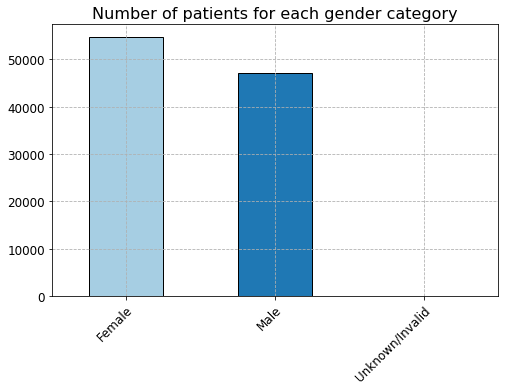

In [14]:
gender_sorted_df = df['gender'].value_counts(dropna=False)
ax = gender_sorted_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
ax.set_title('Number of patients for each gender category', fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.grid(True, linestyle='--');

Due to the predominance of `NaN` values in the `Payer Code` category, we will drop the entire column from the data set.

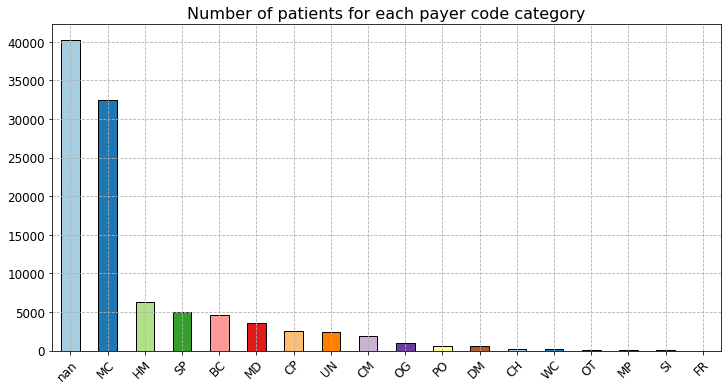

In [15]:
payer_code_sorted_df = df['payer_code'].value_counts(dropna=False)
ax = payer_code_sorted_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(12, 6), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Number of patients for each payer code category', fontsize=16)
plt.grid(True, linestyle='--');

As above, we will drop the `Medical Specialty` columns due to the predominance of `NaN` values.

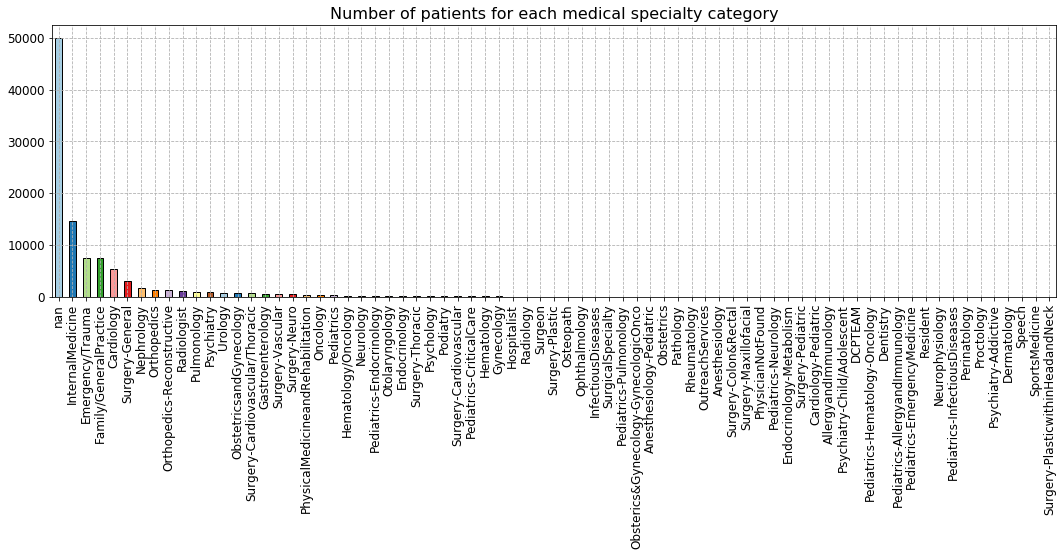

In [16]:
medical_specialty_df = df['medical_specialty'].value_counts(dropna=False)
ax = medical_specialty_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(18, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Number of patients for each medical specialty category', fontsize=16)
plt.grid(True, linestyle='--');

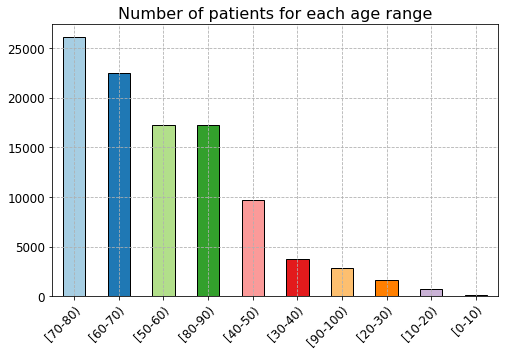

In [17]:
age_df = df['age'].value_counts(dropna=False)
ax = age_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Number of patients for each age range', fontsize=16)
plt.grid(True, linestyle='--');

We want to predict the `readmitted` feature in our data analysis.

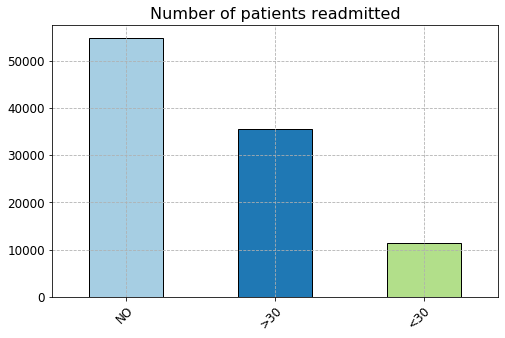

In [18]:
readmitted_df = df['readmitted'].value_counts(dropna=False)
ax = readmitted_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Number of patients readmitted', fontsize=16)
plt.grid(True, linestyle='--');

In [19]:
numeric_cols = list(df.select_dtypes('int64').columns)
print(len(numeric_cols))

10


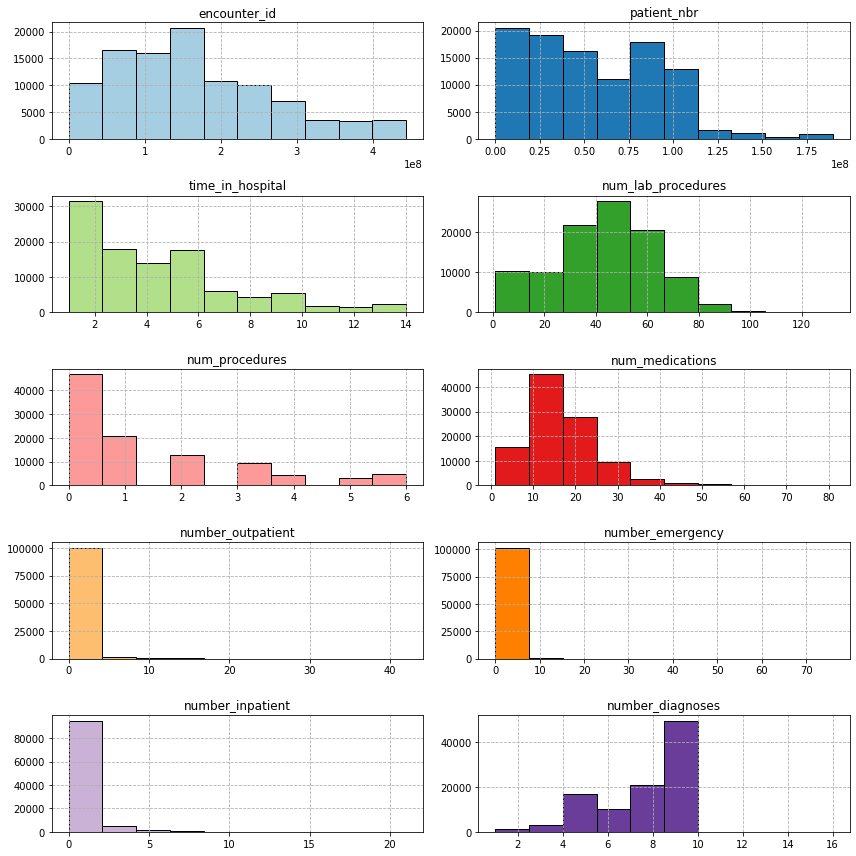

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))
colors = plt.cm.Paired.colors
for c, ax, col in zip(colors, axes.flat, numeric_cols):
    ax.hist(df[col], color=c, edgecolor='k', bins=10)
    ax.set_title(col)
    ax.grid(True, linestyle='--')
fig.tight_layout()

# Data-cleaning

## Removing null and bias values

In [21]:
df.shape

(101766, 50)

We're removing null values for race and `Unknown/Invalid` values for gender.

In [22]:
df = df.loc[df.race.notnull()]
df = df.loc[df.gender != 'Unknown/Invalid', :]

As stated above, we remove `weight`, `medical_specialty` and `payer_code` due to the large presence of `NaN` values. We also remove `encounter_id` since it isn't relevant to our analysis.

In [23]:
df.drop(['weight', 'medical_specialty', 'payer_code', 'encounter_id'], axis=1, inplace=True)

We are also doing away with not available, null, not mapped and unknown/invaild admission type and admission source IDs.

In [24]:
df = df.loc[~df['admission_type_id'].isin([5, 6, 8])]
df = df.loc[~df['admission_source_id'].isin([9, 15, 17, 20, 21])]

In [25]:
df.shape

(88145, 46)

Now we will discard all rows that contains `NaN` values.

In [26]:
df.dropna(how='any', inplace=True)

In [27]:
df.shape

(86887, 46)

According to the [analysis conditions laid out in the research article](https://www.hindawi.com/journals/bmri/2014/781670/), the duplicate patient data were removed to mantain the statistical independence of the data, which is a condition required by logistic regression. Once this is computed, the `patient_nbr` column can be dropped.

In [28]:
df.drop_duplicates(['patient_nbr'], inplace=True)
df.drop(['patient_nbr'], axis=1, inplace=True)

Moreover, all patient data related to discharge to a hospice or patient death were removed to avoid biases. Null patient values were remove as well.

In [29]:
discharged_to_hospice_or_expired_or_null = [11, 13, 14, 18, 19, 20, 21, 25, 26]
df = df.loc[~df['discharge_disposition_id'].isin(discharged_to_hospice_or_expired_or_null)]

In [30]:
df.shape

(56976, 45)

## Grouping primary diagnosis values into group categories

Column values for primary diagnosis, `diag_1`, are encoded in over 700 individual code entries of which the first three digits are listed in each entry. Following the grouping in Table 2 of the article, we can reduce these values to nine major groups, which are `Circulatory`, `Respiratory`, `Digestive`, `Diabetes`, `Injury`, `Musculoskeletal`, `Genitourinary`, `Neoplasms` and `Others`.

In [31]:
circulatory_list = [str(f) for f in list(range(390, 460)) + [785]]
respiratory_list = [str(f) for f in list(range(460, 520)) + [786]]
digestive_list = [str(f) for f in list(range(520, 580)) + [787]]
injury_list = [str(f) for f in list(range(800, 1000))]
musculoskeletal_list = [str(f) for f in list(range(710, 740))]
genitourinary_list = [str(f) for f in list(range(580, 630)) + [788]]
neoplasms_list = [str(f) for f in list(range(140, 240))]
others_list = [str(f) for f in [780, 781, 782, 784] + list(range(790, 800)) + list(range(240, 250)) + \
               list(range(680, 710)) + list(range(251, 280))] + [str(f).zfill(3) for f in list(range(1, 140))] + \
              [str(f) for f in list(range(290, 320))] + \
              [str(f) for f in list(range(280, 290)) + list(range(320, 390)) + list(range(630, 680)) + \
               list(range(740, 760))]

In [32]:
diagnosis_list = [circulatory_list, respiratory_list, digestive_list, injury_list, musculoskeletal_list, \
genitourinary_list, neoplasms_list, others_list]
diagnoses_names = ['circulatory', 'respiratory', 'digestive', 'injury', 'musculoskeletal', 'genitourinary', \
                   'neoplasms', 'others']

In [33]:
for list_, col in zip(diagnosis_list, diagnoses_names):
    filter_ = df['diag_1'].isin(list_)
    df.loc[filter_, col+'_col'] = pd.Categorical([col for i in range(filter_.sum())])

In [34]:
df.shape

(56976, 53)

In [35]:
char_list = ['250.', 'E', 'V']
diag_char_list = ['diabetes', 'others', 'others']

In [36]:
for char, col in zip(char_list, diag_char_list):
    filter_ = df['diag_1'].str.contains(char)
    df.loc[filter_, col+'_col'] = pd.Categorical([col for i in range(filter_.sum())])

In [37]:
df.shape

(56976, 54)

The primary (`diag_1`) and secondary diagnoses (`diag_2`, `diag_3`) are dropped. 

In [38]:
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

In [39]:
df.shape

(56976, 51)

In [40]:
diagnoses_list = [col+'_col' for col in diagnoses_names + ['diabetes']]
df['diagnosis'] = df[diagnoses_list].bfill(axis=1).iloc[:, 0].astype('category')
df.drop(diagnoses_list, axis=1, inplace=True)
df.dropna(how='any', axis=0, inplace=True)

The `circulatory` category tends to be overly represented with respect to all the other categories, considering also that the `others` category contains all of the remaining categories.

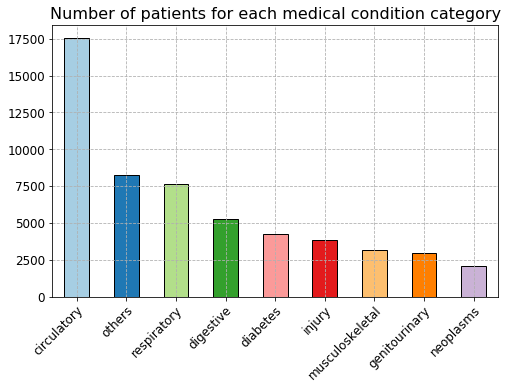

In [41]:
diagnosis_df = df['diagnosis'].value_counts(dropna=False)
ax = diagnosis_df.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_title('Number of patients for each medical condition category', fontsize=16)
plt.grid(True, linestyle='--');

## Grouping `>30 days` and `<30 days ` into the `Yes` category in the `readmitted` column

We're grouping together the `>30` and `<30` categories into the `YES` category.

In [42]:
df['readmitted'].replace(['>30', '<30'], '1', inplace=True)
df['readmitted'].replace(['NO'], '0', inplace=True)
df['readmitted'] = df['readmitted'].astype('int64')

We're resetting the index in order to align and concatenate correctly the new rows of data.

In [43]:
df.reset_index(inplace=True, drop=True)

In [44]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diagnosis
0,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,others
1,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,others
2,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,neoplasms
3,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,circulatory
4,Caucasian,Male,[60-70),3,1,2,4,70,1,21,0,0,0,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,circulatory


In [45]:
df.shape

(55122, 43)

In [46]:
df.nunique().sort_values(ascending=False)

num_lab_procedures          111
num_medications             75 
number_outpatient           29 
number_emergency            18 
discharge_disposition_id    16 
number_diagnoses            14 
admission_source_id         14 
time_in_hospital            14 
number_inpatient            13 
age                         10 
diagnosis                   9  
num_procedures              7  
admission_type_id           5  
race                        5  
miglitol                    4  
chlorpropamide              4  
glyburide-metformin         4  
insulin                     4  
A1Cresult                   4  
metformin                   4  
repaglinide                 4  
nateglinide                 4  
max_glu_serum               4  
glimepiride                 4  
glyburide                   4  
rosiglitazone               4  
pioglitazone                4  
glipizide                   4  
acarbose                    3  
tolbutamide                 2  
troglitazone                2  
tolazami

## Converting categorical variables into dummy variables

I followed the `DictVectorizer` procedure in the [Encoding Categorical Features blog plot on Medium](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c).

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55122 entries, 0 to 55121
Data columns (total 43 columns):
race                        55122 non-null category
gender                      55122 non-null category
age                         55122 non-null category
admission_type_id           55122 non-null category
discharge_disposition_id    55122 non-null category
admission_source_id         55122 non-null category
time_in_hospital            55122 non-null int64
num_lab_procedures          55122 non-null int64
num_procedures              55122 non-null int64
num_medications             55122 non-null int64
number_outpatient           55122 non-null int64
number_emergency            55122 non-null int64
number_inpatient            55122 non-null int64
number_diagnoses            55122 non-null int64
max_glu_serum               55122 non-null category
A1Cresult                   55122 non-null category
metformin                   55122 non-null category
repaglinide                 551

We're just performing the conversion to dummy variables on the columns with categorical values.

In [48]:
cats_cols = list(df.select_dtypes('category').columns)

In [49]:
from sklearn.feature_extraction import DictVectorizer
df_to_dict = df[cats_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dict_to_arr_encoded = dv.fit_transform(df_to_dict)

In [50]:
dict_to_arr_encoded.shape

(55122, 108)

In [51]:
vocab = list(dv.vocabulary_)
df_encoded = pd.concat([df.loc[:, list(df.select_dtypes('int64').columns)], pd.DataFrame(dict_to_arr_encoded, columns=vocab)], axis=1)

In [52]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55122 entries, 0 to 55121
Columns: 117 entries, time_in_hospital to metformin-pioglitazone=Steady
dtypes: float64(108), int64(9)
memory usage: 49.2 MB


In [53]:
df_encoded.shape

(55122, 117)

In [54]:
df_encoded.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race=Caucasian,gender=Female,age=[10-20),admission_type_id,discharge_disposition_id,admission_source_id,max_glu_serum=None,A1Cresult=None,metformin=No,repaglinide=No,nateglinide=No,chlorpropamide=No,glimepiride=No,acetohexamide=No,glipizide=No,glyburide=No,tolbutamide=No,pioglitazone=No,rosiglitazone=No,acarbose=No,miglitol=No,troglitazone=No,tolazamide=No,examide=No,citoglipton=No,insulin=Up,glyburide-metformin=No,glipizide-metformin=No,glimepiride-pioglitazone=No,metformin-rosiglitazone=No,metformin-pioglitazone=No,change=Ch,diabetesMed=Yes,diagnosis=others,race=AfricanAmerican,age=[20-30),glipizide=Steady,insulin=No,change=No,gender=Male,age=[40-50),insulin=Steady,diagnosis=neoplasms,age=[50-60),diagnosis=circulatory,age=[60-70),metformin=Steady,glimepiride=Steady,age=[70-80),glyburide=Steady,age=[80-90),age=[90-100),rosiglitazone=Steady,diagnosis=diabetes,glyburide=Up,repaglinide=Up,insulin=Down,diagnosis=respiratory,diagnosis=injury,diabetesMed=No,race=Other,A1Cresult=>7,acarbose=Steady,diagnosis=genitourinary,metformin=Up,troglitazone=Steady,diagnosis=musculoskeletal,diagnosis=digestive,A1Cresult=>8,age=[30-40),A1Cresult=Norm,glipizide=Down,repaglinide=Steady,glimepiride=Up,tolazamide=Steady,glipizide=Up,glyburide=Down,race=Asian,tolbutamide=Steady,rosiglitazone=Up,chlorpropamide=Steady,pioglitazone=Steady,race=Hispanic,age=[0-10),glimepiride=Down,metformin=Down,acarbose=Up,rosiglitazone=Down,pioglitazone=Up,glyburide-metformin=Steady,pioglitazone=Down,nateglinide=Steady,chlorpropamide=Down,chlorpropamide=Up,repaglinide=Down,glyburide-metformin=Down,glyburide-metformin=Up,nateglinide=Down,miglitol=Steady,acetohexamide=Steady,miglitol=Down,nateglinide=Up,glipizide-metformin=Steady,max_glu_serum=>300,max_glu_serum=Norm,miglitol=Up,max_glu_serum=>200,metformin-pioglitazone=Steady
0,3,59,0,18,0,0,0,9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2,11,5,13,2,0,1,6,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1,51,0,8,0,0,0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3,31,6,16,0,0,0,9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,4,70,1,21,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0

# Saving results

In [55]:
df_encoded.to_csv('data/df_encoded.csv')